# Full Data Pipeline
1. Raw Data Merging
  - combining 2019 and 2020 ISIC data
2. Data Cleaning
  - dropping rows with null diagnosis
  - interpolating columns' missing values
3. Data Processing and Splitting
  - stratifying train/val/test split 80-10-10 (approx 25000-2500-2500)
  - displaying hair removal
  - displaying masking post-hair-removal

4. Writing processed and split data into appropriate folders
5. Class Balancing
  - filtering to only treat the training data
  - undersampling overrepresented classes in training data
  - oversampling underrepresented classes in training data
  - adjusting metadata accordingly
  - augmenting oversampled images and writing images into appropriate folder

## Imports

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.utils import resample
import imgaug.augmenters as iaa
from imgaug import augmenters as iaa
import imageio
import math
from google.colab.patches import cv2_imshow
import random


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Raw Data Merging

### 1a. Combining 2019 and 2020 ISIC data

In [ ]:
# Reading in raw data
df_19 =  pd.read_csv('/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/ISIC/challenge-2019-training_metadata_2024-09-14.csv', low_memory=False)
df_20 =  pd.read_csv('/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/ISIC/challenge-2020-training_metadata_2024-09-14.csv', low_memory=False)

In [ ]:
# Selecting columns
df_19 = df_19[['isic_id', 'age_approx', 'sex', 'anatom_site_general','diagnosis', 'benign_malignant']]
df_20 = df_20[['isic_id', 'age_approx', 'sex', 'anatom_site_general','diagnosis', 'benign_malignant']]

In [ ]:
# Outer joining raw data
merged_df = pd.merge(df_19, df_20, how = 'outer')

In [ ]:
# Renaming columns for simplicity
merged_df.rename({'anatom_site_general': 'localization', 'age_approx': 'age'}, axis=1, inplace=True)

In [ ]:
# Displaying shape of merged dataframe
merged_df.shape

(58457, 6)

In [ ]:
# Displaying first 5 rows of merged dataframe
merged_df.head(20)

,isic_id,age,sex,localization,diagnosis,benign_malignant
0,ISIC_0000000,55.0,female,anterior torso,nevus,benign
1,ISIC_0000001,30.0,female,anterior torso,nevus,benign
2,ISIC_0000002,60.0,female,upper extremity,melanoma,malignant
3,ISIC_0000003,30.0,male,upper extremity,nevus,benign
4,ISIC_0000004,80.0,male,posterior torso,melanoma,malignant
5,ISIC_0000006,25.0,female,posterior torso,nevus,benign
6,ISIC_0000007,25.0,female,posterior torso,nevus,benign
7,ISIC_0000008,30.0,female,anterior torso,nevus,benign
8,ISIC_0000009,30.0,female,anterior torso,nevus,benign
9,ISIC_0000010,35.0,female,posterior torso,nevus,benign


## 2. Data Cleaning

### 2a. dropping rows with null diagnosis

In [ ]:
diagnosis_mapping = {
    'melanoma': 'malignant',
    'basal cell carcinoma': 'malignant',
    'seborrheic keratosis': 'benign',
    'pigmented benign keratosis': 'benign',
    'squamous cell carcinoma': 'malignant',
    'dermatofibroma': 'benign',
    'solar lentigo': 'benign',
}

In [ ]:
# Mapping benign/malignant values based on diagnosis
merged_df['benign_malignant'] = merged_df.apply(
    lambda row: diagnosis_mapping[row['diagnosis']] if pd.isna(row['benign_malignant']) and row['diagnosis'] in diagnosis_mapping else row['benign_malignant'],
    axis=1
)

In [ ]:
# Dropping rows with null diagnosis
merged_clean_df1 = merged_df.dropna(subset=['diagnosis', 'benign_malignant'])

In [ ]:
merged_clean_df1.head()

,isic_id,age,sex,localization,diagnosis,benign_malignant
0,ISIC_0000000,55.0,female,anterior torso,nevus,benign
1,ISIC_0000001,30.0,female,anterior torso,nevus,benign
2,ISIC_0000002,60.0,female,upper extremity,melanoma,malignant
3,ISIC_0000003,30.0,male,upper extremity,nevus,benign
4,ISIC_0000004,80.0,male,posterior torso,melanoma,malignant


In [ ]:
# Drop rows where 'benign_malignant' is 'indeterminate' or 'indeterminate/benign'
merged_clean_df1 = merged_clean_df1[~merged_clean_df1['benign_malignant'].isin(['indeterminate', 'indeterminate/benign'])]

# Verify the counts
merged_clean_df1['benign_malignant'].value_counts()

,count
benign_malignant,
benign,21170
malignant,9058


In [ ]:
# Displaying shape of merged dataframe with dropped null targets
merged_clean_df1.shape

(30228, 6)

### 2b. interpolating columns' missing values

In [ ]:
# Displaying number of null values in dataframe
merged_clean_df1.isnull().sum()

,0
isic_id,0
age,478
sex,381
localization,5180
diagnosis,0
benign_malignant,0


In [ ]:
merged_df.diagnosis.value_counts()

,count
diagnosis,
nevus,18070
melanoma,5106
basal cell carcinoma,3323
seborrheic keratosis,1453
pigmented benign keratosis,1100
actinic keratosis,867
squamous cell carcinoma,628
vascular lesion,253
dermatofibroma,239


In [ ]:
merged_clean_df2 = merged_clean_df1.copy()

In [ ]:
# Interpolating age
merged_clean_df2['age'] =  merged_clean_df2['age'].interpolate(method='linear')

In [ ]:
# Interpolating sex
merged_clean_df2['sex'] =  merged_clean_df2['sex'].interpolate(method='pad')

<ipython-input-19-1f5446c429bb>:2: FutureWarning: Series.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_clean_df2['sex'] =  merged_clean_df2['sex'].interpolate(method='pad')


In [ ]:
# Interpolating localization
merged_clean_df2['localization'] =  merged_clean_df2['localization'].interpolate(method='pad')

<ipython-input-20-94d189147d60>:2: FutureWarning: Series.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_clean_df2['localization'] =  merged_clean_df2['localization'].interpolate(method='pad')


In [ ]:
# Displaying the shape of the interpolated dataframe
merged_clean_df2.shape

(30228, 6)

In [ ]:
# Displaying the first 5 rows of the interpolated dataframe
merged_clean_df2.head()

,isic_id,age,sex,localization,diagnosis,benign_malignant
0,ISIC_0000000,55.0,female,anterior torso,nevus,benign
1,ISIC_0000001,30.0,female,anterior torso,nevus,benign
2,ISIC_0000002,60.0,female,upper extremity,melanoma,malignant
3,ISIC_0000003,30.0,male,upper extremity,nevus,benign
4,ISIC_0000004,80.0,male,posterior torso,melanoma,malignant


In [ ]:
# Displaying the number of null values in each column
merged_clean_df2.isnull().sum()

,0
isic_id,0
age,0
sex,0
localization,0
diagnosis,0
benign_malignant,0


### 2c. dropping rows with diagnoses that are barely populated

In [ ]:
# Copying cleaned data to a new dataframe
merged_clean_df3 = merged_clean_df2.copy()

In [ ]:
# Getting diagnosis counts
diagnosis_counts = merged_clean_df3.diagnosis.value_counts()

In [ ]:
# Removing rows with diagnoses that have fewer than 200 instances
merged_clean_df3 = merged_clean_df3[merged_clean_df3.diagnosis.isin(diagnosis_counts[diagnosis_counts >= 200].index)]

In [ ]:
# Displaying shape: removed 100 images
merged_clean_df3.shape

(30128, 6)

In [ ]:
# Resetting inded for final clean dataset
merged_clean_df3 = merged_clean_df3.reset_index(drop=True)

In [ ]:
merged_clean_df3.head()

,isic_id,age,sex,localization,diagnosis,benign_malignant
0,ISIC_0000000,55.0,female,anterior torso,nevus,benign
1,ISIC_0000001,30.0,female,anterior torso,nevus,benign
2,ISIC_0000002,60.0,female,upper extremity,melanoma,malignant
3,ISIC_0000003,30.0,male,upper extremity,nevus,benign
4,ISIC_0000004,80.0,male,posterior torso,melanoma,malignant


In [ ]:
merged_clean_df3.diagnosis.value_counts()

,count
diagnosis,
nevus,18062
melanoma,5106
basal cell carcinoma,3323
seborrheic keratosis,1453
pigmented benign keratosis,1100
squamous cell carcinoma,628
dermatofibroma,239
solar lentigo,217


### 2 d - Regrouping for 4 Class Model

In [ ]:
def classify_row(row):
    if row['benign_malignant'] == 'benign':
        if row['diagnosis'] == 'nevus':
            return 'nevus'
        else:
            return 'benign other'
    elif row['benign_malignant'] == 'malignant':
        if row['diagnosis'] == 'melanoma':
            return 'melanoma'
        else:
            return 'malignant other'

In [ ]:
# Apply the function to create the 'four_class' column
merged_clean_df3['four_class'] = merged_clean_df3.apply(classify_row, axis=1)

## 3. Data Processing

### 3a. stratifying train/val/test split 80-10-10

In [ ]:
# Making a copy of the cleaned data for stratified splitting
strat_split_df1 = merged_clean_df3.copy()

In [ ]:
# Helper function to perform a stratified split
def stratified_split_with_set_column(df_in, feature_col, target_col):
  df = df_in.copy()
  # First, split the data into 80% train and 20% temp sets
  X = df[feature_col]
  y = df[target_col]

  # Split into train (80%) and temp (20%)
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

  # Split the temp set into validation (10%) and test (10%)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

  # Add a 'set' column to the original dataframe
  df['set'] = 'training'
  df.loc[df[feature_col].isin(X_val), 'set'] = 'validation'
  df.loc[df[feature_col].isin(X_test), 'set'] = 'test'

  return df

In [ ]:
# Performing the stratified split
strat_split_df2 = stratified_split_with_set_column(strat_split_df1, 'isic_id', 'four_class') # changed to 4 class

In [ ]:
# Checking for correct split
strat_split_df2['set'].value_counts()

,count
set,
training,24102
test,3013
validation,3013


In [ ]:
strat_split_df2.head(20)

,isic_id,age,sex,localization,diagnosis,benign_malignant,four_class,set
0,ISIC_0000000,55.0,female,anterior torso,nevus,benign,nevus,training
1,ISIC_0000001,30.0,female,anterior torso,nevus,benign,nevus,training
2,ISIC_0000002,60.0,female,upper extremity,melanoma,malignant,melanoma,training
3,ISIC_0000003,30.0,male,upper extremity,nevus,benign,nevus,training
4,ISIC_0000004,80.0,male,posterior torso,melanoma,malignant,melanoma,training
5,ISIC_0000006,25.0,female,posterior torso,nevus,benign,nevus,training
6,ISIC_0000007,25.0,female,posterior torso,nevus,benign,nevus,test
7,ISIC_0000008,30.0,female,anterior torso,nevus,benign,nevus,test
8,ISIC_0000009,30.0,female,anterior torso,nevus,benign,nevus,training
9,ISIC_0000010,35.0,female,posterior torso,nevus,benign,nevus,training


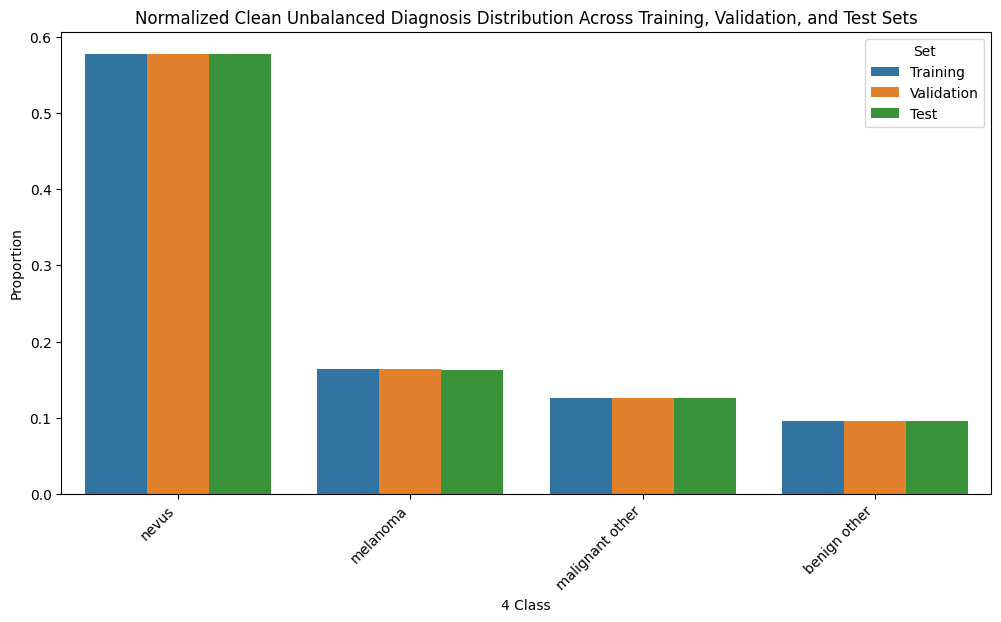

In [ ]:
# Displaying the diagnosis distribution for train, validation, and test data
def plot_split_distribution(strat_split_df2):
    # Calculate the normalized diagnosis distribution for each set
    train_counts = strat_split_df2[strat_split_df2['set'] == 'training']["four_class"].value_counts() / 25004
    val_counts = strat_split_df2[strat_split_df2['set'] == 'validation']["four_class"].value_counts() / 3126
    test_counts = strat_split_df2[strat_split_df2['set'] == 'test']["four_class"].value_counts() / 3126

    # Create a DataFrame to combine the counts into one for easy plotting
    distribution_df = pd.DataFrame({
        # 'Diagnosis': train_counts.index,
        'four_class': train_counts.index,
        'Training': train_counts.values,
        'Validation': val_counts.values,
        'Test': test_counts.values
    }).melt(id_vars='four_class', var_name='Set', value_name='Proportion')

    # Create the plot using seaborn
    plt.figure(figsize=(12, 6))
    sns.barplot(x='four_class', y='Proportion', hue='Set', data=distribution_df)

    # Add title and labels
    plt.title('Normalized Clean Unbalanced Diagnosis Distribution Across Training, Validation, and Test Sets')
    plt.ylabel('Proportion')
    plt.xlabel('4 Class')
    plt.legend(title='Set')
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.show()

# Applying the function
plot_split_distribution(strat_split_df2)


### 3 a 2. undersampling overrepresented classes in training data

In [ ]:
# Defining dataframe containing only training data
train_data = strat_split_df2[strat_split_df2['set'] == 'training']

In [ ]:
# Displaying training data shape
train_data.shape

(24102, 8)

In [ ]:
# Displaying training data head
train_data.head()

,isic_id,age,sex,localization,diagnosis,benign_malignant,four_class,set
0,ISIC_0000000,55.0,female,anterior torso,nevus,benign,nevus,training
1,ISIC_0000001,30.0,female,anterior torso,nevus,benign,nevus,training
2,ISIC_0000002,60.0,female,upper extremity,melanoma,malignant,melanoma,training
3,ISIC_0000003,30.0,male,upper extremity,nevus,benign,nevus,training
4,ISIC_0000004,80.0,male,posterior torso,melanoma,malignant,melanoma,training


In [ ]:
# Displaying class distribution
train_data['four_class'].value_counts()

,count
four_class,
nevus,14449
melanoma,4085
malignant other,3162
benign other,2406


In [ ]:
target_size = np.round(((18062 + 5106 + 3952 + 3008)*0.8)/4, 0)
target_size

6026.0

In [ ]:
# Define the target sizes for downsizing each overrepresented class
target_sizes_down = {
    'nevus': 5026, # down 1k extra
    'melanoma': 6026, # need to keep in or the value gets removed
    'benign other': 6026,
    'malignant other': 6026
  }

In [ ]:
# Separating the data by class and undersampling
df_list = []
for four_class, target_size in target_sizes_down.items():
    df_class = train_data[train_data['four_class'] == four_class]
    if len(df_class) > target_size:
        # Downsample if class is larger than the target size
        df_class_resampled = resample(df_class,
                                      replace=False,  # Sampling without replacement
                                      n_samples=target_size,
                                      random_state=77)
    else:
        df_class_resampled = df_class
    df_list.append(df_class_resampled)

In [ ]:
# Concatenating data for all undersampled classes
df_undersampled = pd.concat(df_list)

In [ ]:
# Displaying the undersampled training data's shape
df_undersampled.shape

(14679, 8)

In [ ]:
# Displaying the undersampled training data's diagnosis counts
df_undersampled.diagnosis.value_counts(), df_undersampled.four_class.value_counts()

(diagnosis
 nevus                         5026
 melanoma                      4085
 basal cell carcinoma          2647
 seborrheic keratosis          1163
 pigmented benign keratosis     867
 squamous cell carcinoma        515
 dermatofibroma                 190
 solar lentigo                  186
 Name: count, dtype: int64,
 four_class
 nevus              5026
 melanoma           4085
 malignant other    3162
 benign other       2406
 Name: count, dtype: int64)

### 3b. hair removal function

In [ ]:
def display_remove_hair(image_path, white_pixel_threshold=1000):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a black-hat filter (which highlights dark objects like hair on a light background)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # Apply a binary threshold to get the hair mask
    _, hair_mask = cv2.threshold(blackhat, 20, 255, cv2.THRESH_BINARY)

    # Calculate the sum of white pixels in the mask
    white_pixel_count = np.sum(hair_mask == 255)

    # If the number of white pixels is below the threshold, skip inpainting
    if white_pixel_count < white_pixel_threshold:
        print(f"White pixels ({white_pixel_count}) below threshold ({white_pixel_threshold}), skipping inpainting.")

        # Display the original image
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image (No Hair Detected)')
        plt.axis('off')
        plt.show()

        return image  # Return the original image since no significant hair was detected

    # Inpaint the original image using the hair mask
    inpainted_image = cv2.inpaint(image, hair_mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

    # Display original, binary mask, and inpainted image
    plt.figure(figsize=(18, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Binary mask
    plt.subplot(1, 3, 2)
    plt.imshow(hair_mask, cmap='gray')
    plt.title('Binary Mask (Hair Detection)')
    plt.axis('off')

    # Inpainted image
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
    plt.title('Inpainted Image (Hair Removed)')
    plt.axis('off')

    plt.show()

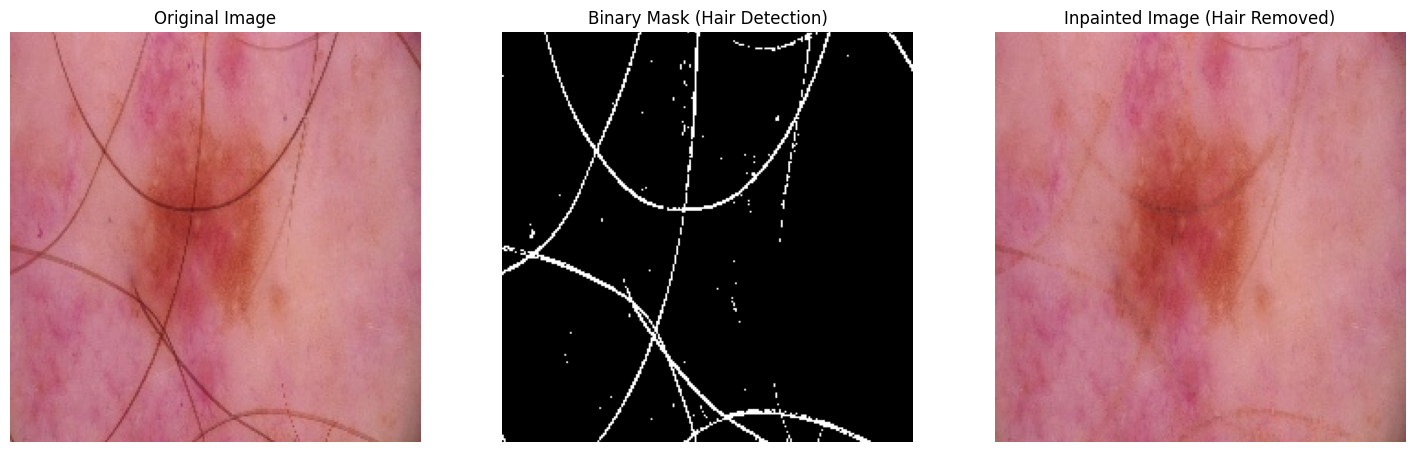

In [ ]:
example_image_path1 ='/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/ISIC_processed/ISIC_0157923.jpg'
display_remove_hair(example_image_path1)

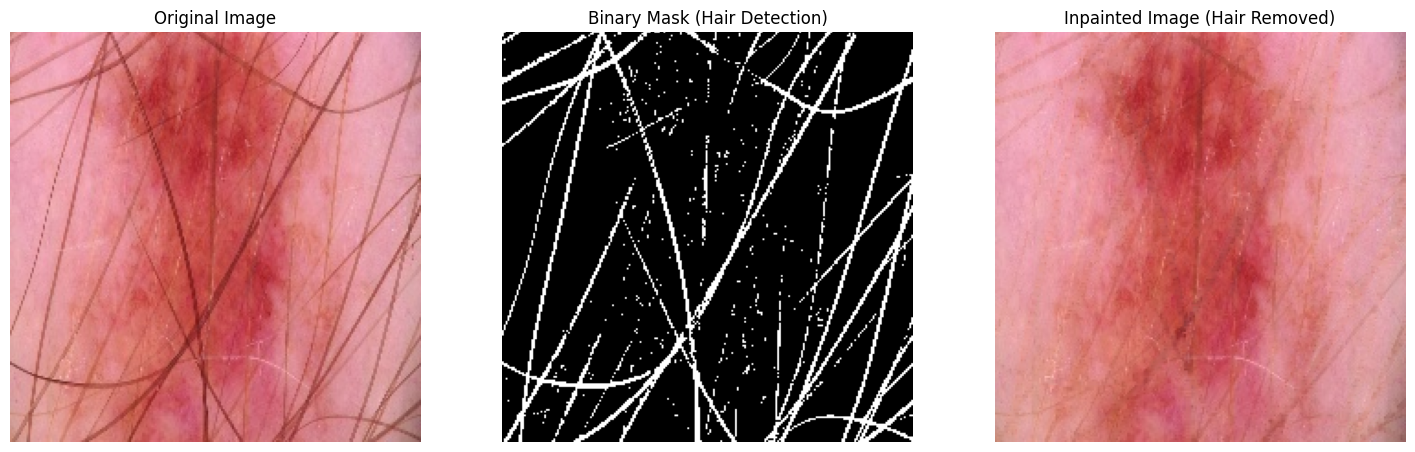

In [ ]:
example_image_path2 = '/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/ISIC_processed/ISIC_0091016.jpg'
display_remove_hair(example_image_path2)

### 3c. masking function

In [ ]:
# Downloading libraries for masking
!pip install -U torch torchvision torchaudio
!pip install git+https://github.com/facebookresearch/detectron2.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Importing libraries for masking
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [ ]:
# Reading in the saved masking model and configuration
save_dir = '/content/drive/MyDrive/MIDS 210A - Capstone Project/Code'
model_weights_path = os.path.join(save_dir, 'mask_rcnn_model_weights.pth')
config_path = os.path.join(save_dir, 'mask_rcnn_config.yaml')

# Loading the configuration and model weights
cfg = get_cfg()
cfg.merge_from_file(config_path)  # Loading the saved configuration
cfg.MODEL.WEIGHTS = model_weights_path  # Loading the saved model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Setting the threshold for inference

# Initializing the predictor with the saved model
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

In [ ]:
def remove_hair_and_mask(image_path, white_pixel_threshold=1000):
    # 1. Hair Removal
    # Convert the image to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a black-hat filter (which highlights dark objects like hair on a light background)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # Apply a binary threshold to get the hair mask
    _, hair_mask = cv2.threshold(blackhat, 20, 255, cv2.THRESH_BINARY)

    # Calculate the sum of white pixels in the mask
    white_pixel_count = np.sum(hair_mask == 255)

    # Inpaint the original image using the hair mask if significant hair is detected
    if white_pixel_count >= white_pixel_threshold:
        image = cv2.inpaint(image, hair_mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

    # 2. Mask Generation
    # Convert the inpainted image to RGB format (cv2 reads images as BGR)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get predicted masks using the trained model
    outputs = predictor(img_rgb)  # Run the model prediction

    # Extract predicted masks and confidence scores
    predicted_masks = outputs["instances"].pred_masks.to("cpu").numpy()
    predicted_scores = outputs["instances"].scores.to("cpu").numpy()

    # Check if any mask was detected
    if len(predicted_scores) > 0:
        # Select the mask with the highest confidence score
        highest_confidence_index = np.argmax(predicted_scores)
        highest_confidence_mask = predicted_masks[highest_confidence_index]

        # Apply the mask directly to the image (binary mask)
        binary_predicted_mask = (highest_confidence_mask > 0).astype(np.uint8)

        # Apply the mask on the inpainted image
        image_masked = cv2.bitwise_and(image, image, mask=binary_predicted_mask * 255)

        image = image_masked
        print('Mask was detected for this image.')
    # Return the inpainted image without further masking if no mask was detected
    else:
        print('No mask was detected for this image.')

    return image

## 4. Writing processed and split data into appropriate folders

In [ ]:
'''
# Writing processed split data into appropriate folders: do not re-run
# This way is much slower and involves actually loading in the masking model

for i in range(len(strat_split_df2)):
  set_i = strat_split_df2.iloc[i]['set']
  four_class_i = strat_split_df2.iloc[i]['four_class']
  id_i = strat_split_df2.iloc[i]['isic_id']
  og_img_path = '/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/ISIC_processed/'+id_i+'.jpg'
  out_img_path = '/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/'+set_i+'/'+four_class_i
  if not os.path.exists(out_img_path):
    os.makedirs(out_img_path)
  out_img_name = out_img_path+'/'+id_i+'.jpg'
  img_processed = remove_hair_and_mask(og_img_path)
  cv2.imwrite(out_img_name, img_processed)
  print(i)
'''

Streaming output truncated to the last 5000 lines.
Mask was detected for this image.
27628
Mask was detected for this image.
27629
Mask was detected for this image.
27630
Mask was detected for this image.
27631
Mask was detected for this image.
27632
Mask was detected for this image.
27633
Mask was detected for this image.
27634
Mask was detected for this image.
27635
Mask was detected for this image.
27636
Mask was detected for this image.
27637
Mask was detected for this image.
27638
Mask was detected for this image.
27639
Mask was detected for this image.
27640
Mask was detected for this image.
27641
Mask was detected for this image.
27642
Mask was detected for this image.
27643
Mask was detected for this image.
27644
Mask was detected for this image.
27645
Mask was detected for this image.
27646
Mask was detected for this image.
27647
No mask was detected for this image.
27648
Mask was detected for this image.
27649
Mask was detected for this image.
27650
Mask was detected for this

### 4b. Checking/Removing unneeded masked images

In [ ]:
# Define paths
training_path = '/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/training'
subfolders = ['benign other', 'malignant other', 'melanoma', 'nevus']

In [ ]:
# Find the ISIC IDs in strat_split_df2 but not in df_undersampled
missing_isic_ids = strat_split_df2[~strat_split_df2['isic_id'].isin(df_undersampled['isic_id'])]['isic_id']

# Display the results
print(missing_isic_ids)

1        ISIC_0000001
5        ISIC_0000006
6        ISIC_0000007
7        ISIC_0000008
8        ISIC_0000009
             ...     
30120    ISIC_9988236
30121    ISIC_9990676
30122    ISIC_9991967
30123    ISIC_9995691
30126    ISIC_9998937
Name: isic_id, Length: 15449, dtype: object


In [ ]:
# Convert to a set for faster lookup
missing_isic_ids_set = set(missing_isic_ids)

In [ ]:
'''
# Iterate over each subfolder in the training directory
for subfolder in subfolders:
    folder_path = os.path.join(training_path, subfolder)

    # List all files in the subfolder
    for filename in os.listdir(folder_path):
        # Extract the ISIC ID from the filename
        isic_id = filename.split('.')[0]  # Removes '.jpg'

        # Check if this ISIC ID is in the list of missing IDs
        if isic_id in missing_isic_ids_set:
            # Full path of the file to be removed
            file_path = os.path.join(folder_path, filename)

            # Remove the file
            os.remove(file_path)
            print(f"Removed: {file_path}")
'''

Streaming output truncated to the last 5000 lines.
Removed: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/training/nevus/ISIC_0034044.jpg
Removed: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/training/nevus/ISIC_0034045.jpg
Removed: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/training/nevus/ISIC_0034056.jpg
Removed: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/training/nevus/ISIC_0034072.jpg
Removed: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/training/nevus/ISIC_0034077.jpg
Removed: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/training/nevus/ISIC_0034078.jpg
Removed: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/training/nevus/

In [ ]:
# Check number of files

# Iterate through each subfolder and count files
for subfolder in subfolders:
    folder_path = os.path.join(training_path, subfolder)

    # Count the number of files in the folder
    num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

    # Print the count
    print(f"Number of files in '{subfolder}': {num_files}")

Number of files in 'benign other': 2406
Number of files in 'malignant other': 3162
Number of files in 'melanoma': 4085
Number of files in 'nevus': 5026


this matches... yay!

## 5. Class Balancing

### 5a. selecting the training data only for balancing

In [ ]:
# Defining dataframe containing only training data
train_data = strat_split_df2[strat_split_df2['set'] == 'training']

In [ ]:
# Displaying training data shape
train_data.shape

(24102, 8)

In [ ]:
# Displaying training data head
train_data.head()

,isic_id,age,sex,localization,diagnosis,benign_malignant,four_class,set
0,ISIC_0000000,55.0,female,anterior torso,nevus,benign,nevus,training
1,ISIC_0000001,30.0,female,anterior torso,nevus,benign,nevus,training
2,ISIC_0000002,60.0,female,upper extremity,melanoma,malignant,melanoma,training
3,ISIC_0000003,30.0,male,upper extremity,nevus,benign,nevus,training
4,ISIC_0000004,80.0,male,posterior torso,melanoma,malignant,melanoma,training


In [ ]:
# Displaying class distribution
train_data['four_class'].value_counts()

,count
four_class,
nevus,14449
melanoma,4085
malignant other,3162
benign other,2406


### 5c. oversampling underrepresented classes in training data

In [ ]:
# Define the target sizes for upsampling each underrepresented class
target_sizes_up = {
    'nevus': 6026,
    'melanoma': 6026,
    'benign other': 6026,
    'malignant other': 6026
  }

In [ ]:
# Separating the data by class and oversampling
df_list = []

for four_class, target_size in target_sizes_up.items():
    df_class = df_undersampled[df_undersampled['four_class'] == four_class]
    unique_isics = df_class['isic_id'].nunique()  # Count unique ISICs
    if len(df_class) < target_size:
        # If we need to upsample
        # Step 1: Add all unique samples
        df_class_unique = df_class.drop_duplicates(subset='isic_id')
        # Step 2: Upsample only the remaining required samples
        remaining_needed = target_size - len(df_class_unique)
        if remaining_needed > 0:
            df_class_resampled = resample(df_class_unique,
                                          replace=True,  # Only resample with replacement for the remaining needed
                                          n_samples=remaining_needed,
                                          random_state=77)
            # Combine unique and resampled
            df_class_final = pd.concat([df_class_unique, df_class_resampled])
        else:
            df_class_final = df_class_unique
    else:
        # If the class size is already sufficient, keep it as is
        df_class_final = df_class
    # Add the balanced class to the list
    df_list.append(df_class_final)

# Concatenate all balanced classes to form the final DataFrame
df_oversampled = pd.concat(df_list)

In [ ]:
# Displaying the oversampled training data's shape
df_oversampled.shape

(24104, 8)

In [ ]:
# Displaying the balanced training data's diagnosis counts
df_oversampled.four_class.value_counts()

,count
four_class,
nevus,6026
melanoma,6026
benign other,6026
malignant other,6026


In [ ]:
# Displaying the value counts for isic_id's
df_oversampled.isic_id.value_counts()

,count
isic_id,
ISIC_0072075,8
ISIC_0030661,8
ISIC_0028662,7
ISIC_0024612,7
ISIC_0032773,7
...,...
ISIC_0031729,1
ISIC_0072690,1
ISIC_9688617,1


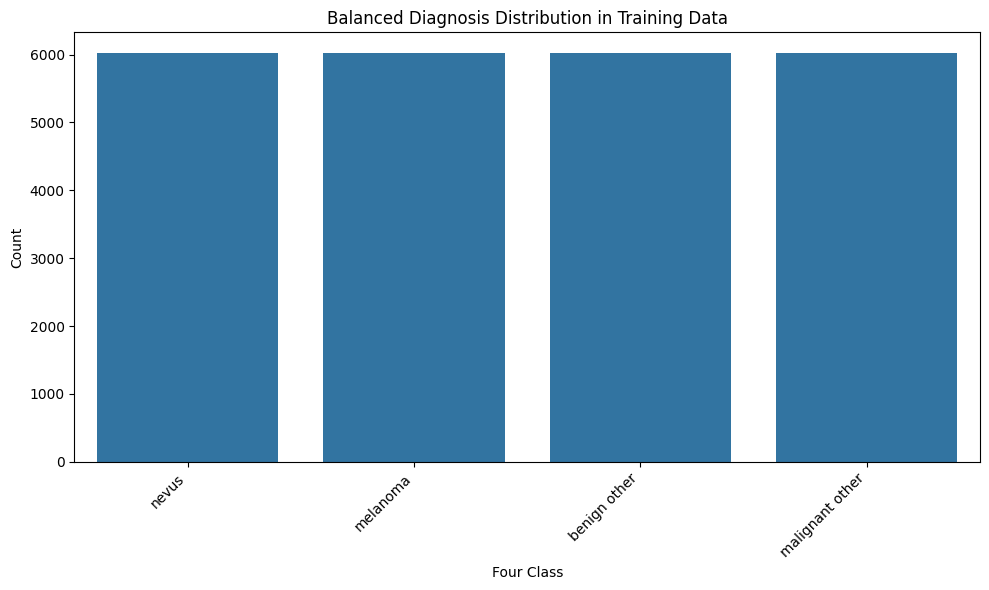

In [ ]:
# Get the value counts
four_class = df_oversampled['four_class'].value_counts()

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=four_class.index, y=four_class.values)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add labels and title
plt.xlabel('Four Class')
plt.ylabel('Count')
plt.title('Balanced Diagnosis Distribution in Training Data')

# Show the plot
plt.tight_layout()
plt.show()

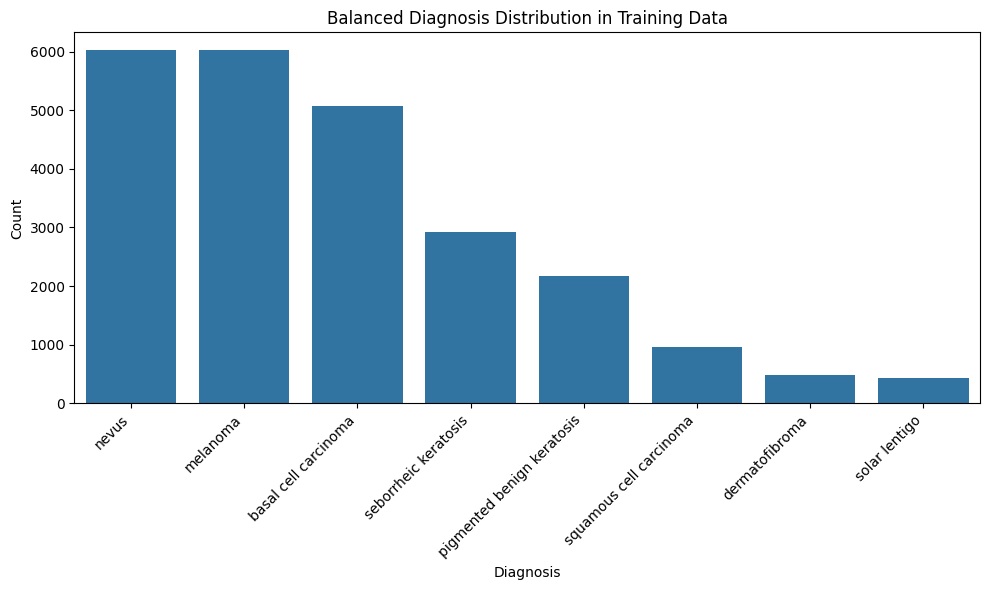

In [ ]:
# Get the value counts
diagnosis_counts = df_oversampled['diagnosis'].value_counts()

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add labels and title
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Balanced Diagnosis Distribution in Training Data')

# Show the plot
plt.tight_layout()
plt.show()

### 5d. adjusting metadata accordingly

In [ ]:
# Differentiating original isic_id from augmented isic_id's by adding a suffix
def add_suffix_to_duplicates(df):
    # Create a new column for counting duplicates
    df2 = df.copy()
    df2['isic_id_count'] = df2.groupby('isic_id').cumcount()

    # Add the suffix to duplicate 'isic_id' values
    df2['isic_id'] = df2.apply(lambda row: f"{row['isic_id']}_{row['isic_id_count']}" if row['isic_id_count'] > 0 else str(row['isic_id']), axis=1)

    # Drop the temporary counting column
    df2 = df2.drop(columns='isic_id_count')

    return df2

df_balanced1 = add_suffix_to_duplicates(df_oversampled)

In [ ]:
# Concatenating suffixed balanced training data with test and validation data
df_test_val = strat_split_df2[(strat_split_df2['set']=='test') | (strat_split_df2['set']=='validation')]
df_balanced2 = pd.concat([df_balanced1, df_test_val])

In [ ]:
df_balanced1.shape, df_balanced2.shape

((24104, 8), (30130, 8))

In [ ]:
df_balanced2.to_csv('/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/mod3_pipeline_metadata.csv')

In [ ]:
# Creating function to return all rows in the dataframe that root from the same original image
def get_duplicates(df, isic_id):
  # Convert the input id to string for comparison
  isic_id = str(isic_id)
  # Filter rows where the 'isic_id' starts with the given id and optionally has suffixes like _1, _2, etc.
  duplicates = df[df['isic_id'].str.startswith(isic_id)]
  return duplicates

In [ ]:
# Example usage of get_duplicates
get_duplicates(df_balanced1, 'ISIC_0072782')

,isic_id,age,sex,localization,diagnosis,benign_malignant,four_class,set
23920,ISIC_0072782,85.0,female,head/neck,solar lentigo,benign,benign other,training


In [ ]:
# Creating function to extract base ISIC ID
def extract_base_isic_id(isic_id):
    # Use regex to match the base isic_id (everything before the last underscore and number)
    match = re.match(r'^(ISIC_\d+)(?:_\d+)?$', str(isic_id))
    if match:
        return match.group(1)
    return None

In [ ]:
# Example usage of extract_base_isic_id
extract_base_isic_id('ISIC_0072782_10')

'ISIC_0072782'

### 5e. augmenting oversampled images and writing images into appropriate folder

#### creating and testing augmenters

In [ ]:
## Creating augmenters
augmenters_color = [
    ('Brighten 1', iaa.Multiply((1)), "Simulates overexposed or underexposed images, mimicking real-world lighting variation on skin."),
    ('Darken 1', iaa.Multiply((0.5)), "Simulates overexposed or underexposed images, mimicking real-world lighting variation on skin."),
    ('Blur 1', iaa.GaussianBlur(sigma=(2)), "Simulates slight out-of-focus effects, improving robustness against blur."),
    ('Sharpen 1', iaa.Sharpen(alpha=(0.25), lightness=(1.2)), "Enhances lesion edges, allowing the model to better detect boundary details."),
    ('Unsaturate 1', iaa.AddToHueAndSaturation((-15)), "Adjusts skin tone variations, ensuring robustness to different pigmentation."),
    ('Saturate 1', iaa.AddToHueAndSaturation((5)), "Adjusts skin tone variations, ensuring robustness to different pigmentation."),
    ('Increase Contrast 1', iaa.contrast.LinearContrast(alpha=(1.5)), "Increases contrast, making lesions stand out more clearly from the surrounding skin."),
    ('Brighten 2', iaa.Multiply((1.3)), "Simulates overexposed or underexposed images, mimicking real-world lighting variation on skin."),
    ('Darken 2', iaa.Multiply((.7)), "Simulates overexposed or underexposed images, mimicking real-world lighting variation on skin."),
    ('Blur 2', iaa.GaussianBlur(sigma=(3)), "Simulates slight out-of-focus effects, improving robustness against blur."),
    ('Sharpen 2', iaa.Sharpen(alpha=(0.5), lightness=(1.2)), "Enhances lesion edges, allowing the model to better detect boundary details."),
    ('Unsaturate 2', iaa.AddToHueAndSaturation((-5)), "Adjusts skin tone variations, ensuring robustness to different pigmentation."),
    ('Saturate 2', iaa.AddToHueAndSaturation((15)), "Adjusts skin tone variations, ensuring robustness to different pigmentation."),
    ('Increase Contrast 2', iaa.contrast.LinearContrast(alpha=(2.0)), "Increases contrast, making lesions stand out more clearly from the surrounding skin.")
]

augmenters_geometric = [
    ('Horizontal', iaa.Fliplr(1.0), "Balances the model if lesions appear in different orientations, common in dermatoscopic images."),
    ('Vertical', iaa.Flipud(1.0), "Balances the model if lesions appear in different orientations, common in dermatoscopic images."),
    ('45 deg', iaa.Affine(rotate=(45)), "Simulates more significant variations in the camera angle, providing a wider range of orientations for the model to generalize from."),
    ('90 deg', iaa.Affine(rotate=(90)), "Simulates more significant variations in the camera angle, providing a wider range of orientations for the model to generalize from."),
    ('135 deg', iaa.Affine(rotate=(135)), "Simulates more significant variations in the camera angle, providing a wider range of orientations for the model to generalize from."),
    ('225 deg', iaa.Affine(rotate=(225)), "Simulates more significant variations in the camera angle, providing a wider range of orientations for the model to generalize from."),
    ('270 deg', iaa.Affine(rotate=(270)), "Simulates more significant variations in the camera angle, providing a wider range of orientations for the model to generalize from."),
    ('315 deg', iaa.Affine(rotate=(315)), "Simulates more significant variations in the camera angle, providing a wider range of orientations for the model to generalize from."),
    ('Zoom', iaa.Affine(scale=(1.2)), "Simulates closer views of the lesion, mimicking zoomed-in images."),
    ('Translate X', iaa.Affine(translate_percent={"x": (-0.2)}), "Shifts the image horizontally to reduce bias toward a specific position."),
    ('Translate Y', iaa.Affine(translate_percent={"y": (0.2)}), "Shifts the image vertically to reduce bias toward a specific position."),
]

augmenters_warping = [
    ('Elastic 1', iaa.ElasticTransformation(alpha=30, sigma=5), "Applies random elastic distortions to simulate skin stretching."),
    ('Cutout 1', iaa.Cutout(nb_iterations=1, size=(0.2, 0.2), fill_mode="constant",  cval=0, position="center"), "Randomly masks out sections of the image, simulating occlusion."),
    ('Dropout 1', iaa.Dropout(p=0.1), "Randomly sets larger square areas of pixels to zero, simulating noise and forcing the model to learn from the remaining pixels."),
    ('Elastic 2', iaa.ElasticTransformation(alpha=45, sigma=8), "Applies random elastic distortions to simulate skin stretching."),
    ('Cutout 2', iaa.Cutout(nb_iterations=1, size=(0.5, 0.5), fill_mode="constant",  cval=0, position="right-center"), "Randomly masks out sections of the image, simulating occlusion."),
    ('Dropout 2', iaa.Dropout(p=0.2), "Randomly sets larger square areas of pixels to zero, simulating noise and forcing the model to learn from the remaining pixels."),
    ('Piecewise Affine 1', iaa.PiecewiseAffine(scale=(0.1)), "Applies small-scale random affine transformations to local regions, mimicking subtle skin deformations."),
    ('Perspective 1', iaa.PerspectiveTransform(scale=(0.1)), "Applies a random perspective transformation to simulate viewpoint changes or camera angles.")
]



In [ ]:
# Building function to display each set of augmenters
def display_augmentations(augmenters, image_i):
  # Define the number of rows and columns (for 2 rows)
  num_augmentations = len(augmenters)
  num_cols = math.ceil((num_augmentations + 1) / 2)  # +1 for the original image
  # Read the original image
  four_class = df_balanced1.iloc[image_i]['four_class']
  isic_id = df_balanced1.iloc[image_i]['isic_id']
  in_img_path = f'/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/training/{four_class}/{isic_id}.jpg'
  # Read the image
  img = cv2.imread(in_img_path)
  # Convert BGR (OpenCV) to RGB (Matplotlib)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # Create subplots with 2 rows and calculated number of columns
  fig, axs = plt.subplots(2, num_cols, figsize=(15, 10))
  # Flatten the axes array to make it easier to index
  axs = axs.ravel()
  # Plot original image
  axs[0].imshow(img_rgb)
  axs[0].set_title('Original')
  axs[0].axis('off')  # Hide axis
  # Loop over augmenters and display augmented images
  for i in range(num_augmentations):
      augmenter_name, augmenter_func, augmenter_description = augmenters[i]  # Unpack tuple
      # Apply augmentation
      augmented_img = augmenter_func.augment_image(img)
      # Convert augmented image from BGR to RGB
      augmented_img_rgb = cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB)
      # Plot augmented image
      axs[i + 1].imshow(augmented_img_rgb)
      axs[i + 1].set_title(f'{augmenter_name}')
      axs[i + 1].axis('off')  # Hide axis
  # Turn off any remaining empty subplots (in case of an uneven number of augmenters)
  for j in range(num_augmentations + 1, len(axs)):
      axs[j].axis('off')
  # Show the plot
  plt.tight_layout()
  plt.show()

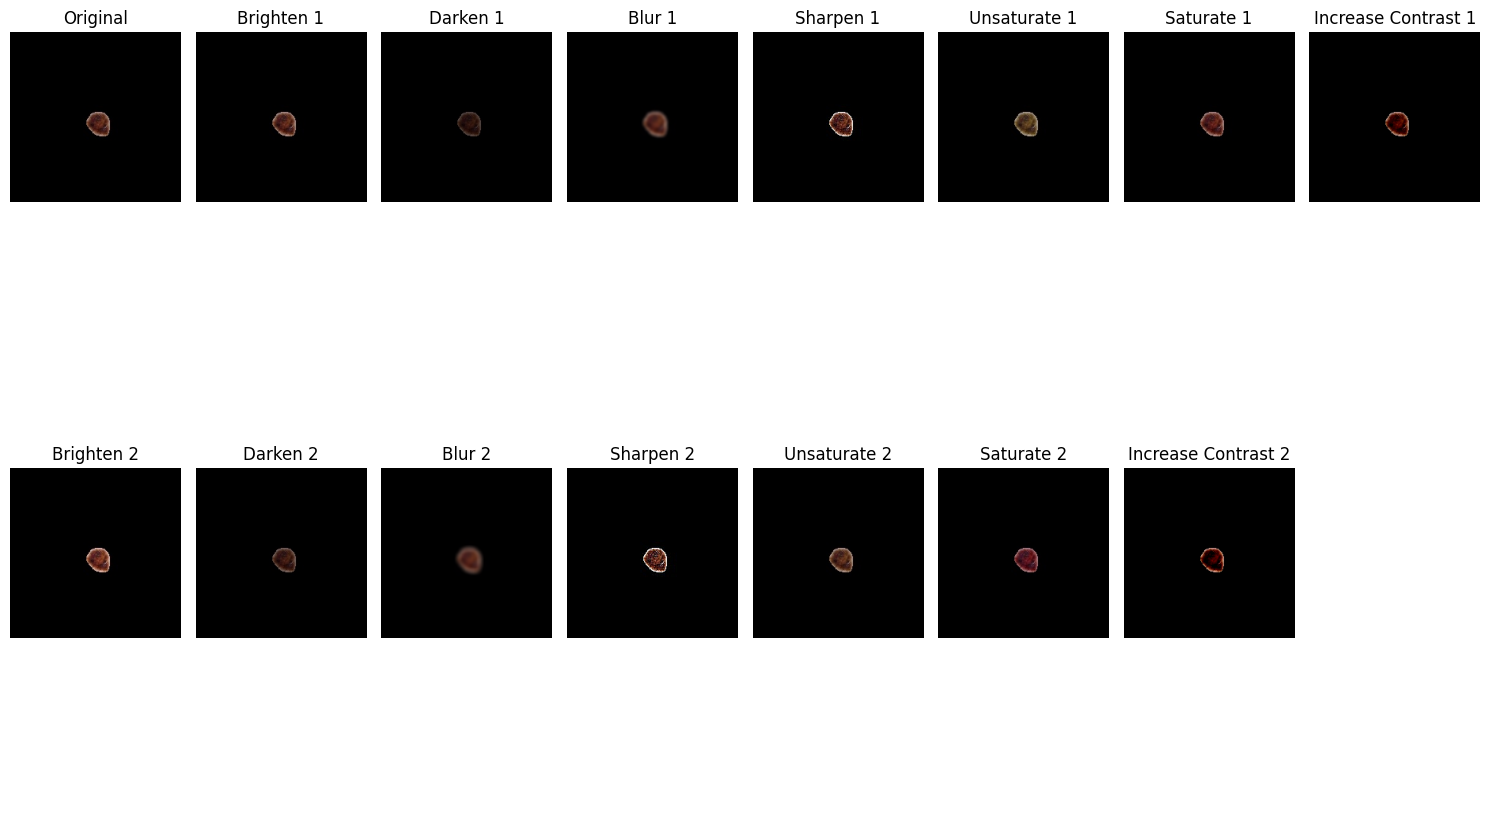

In [ ]:
display_augmentations(augmenters_color, 0)

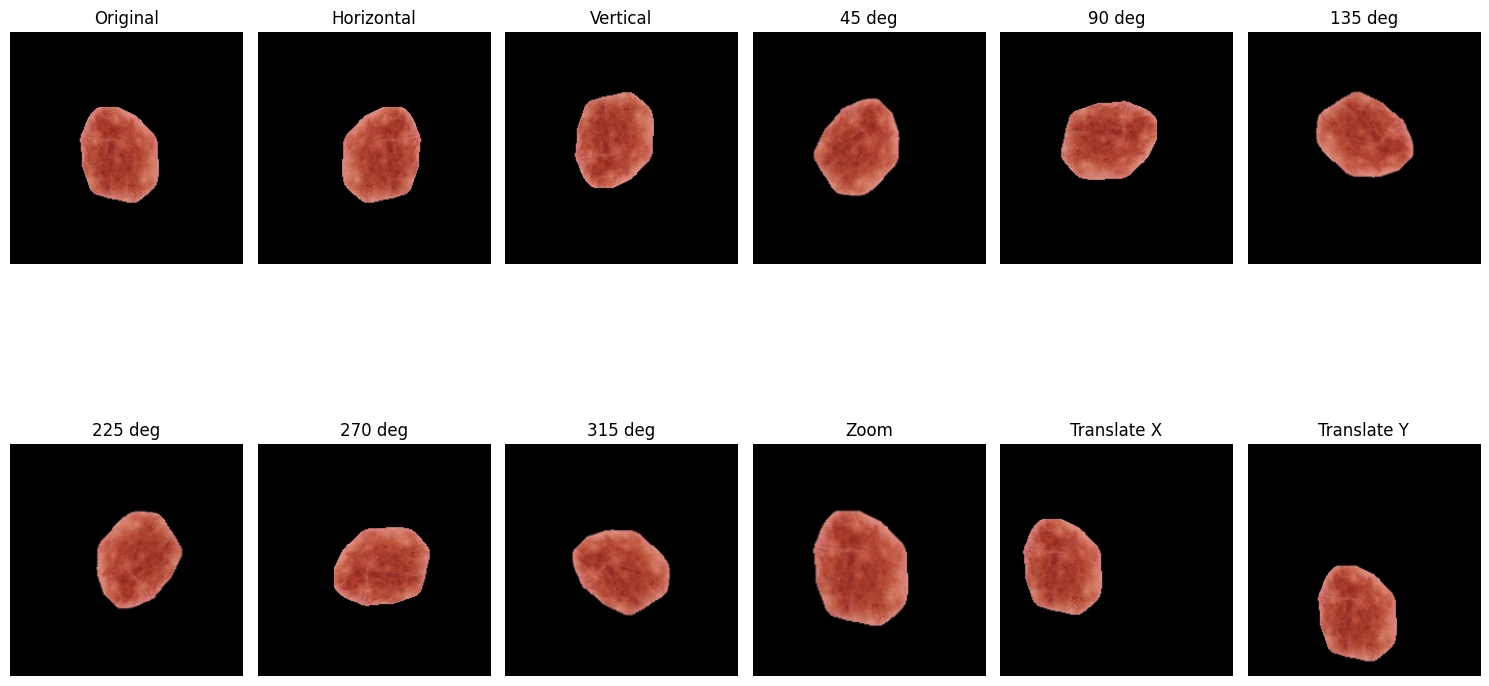

In [ ]:
display_augmentations(augmenters_geometric, 50)

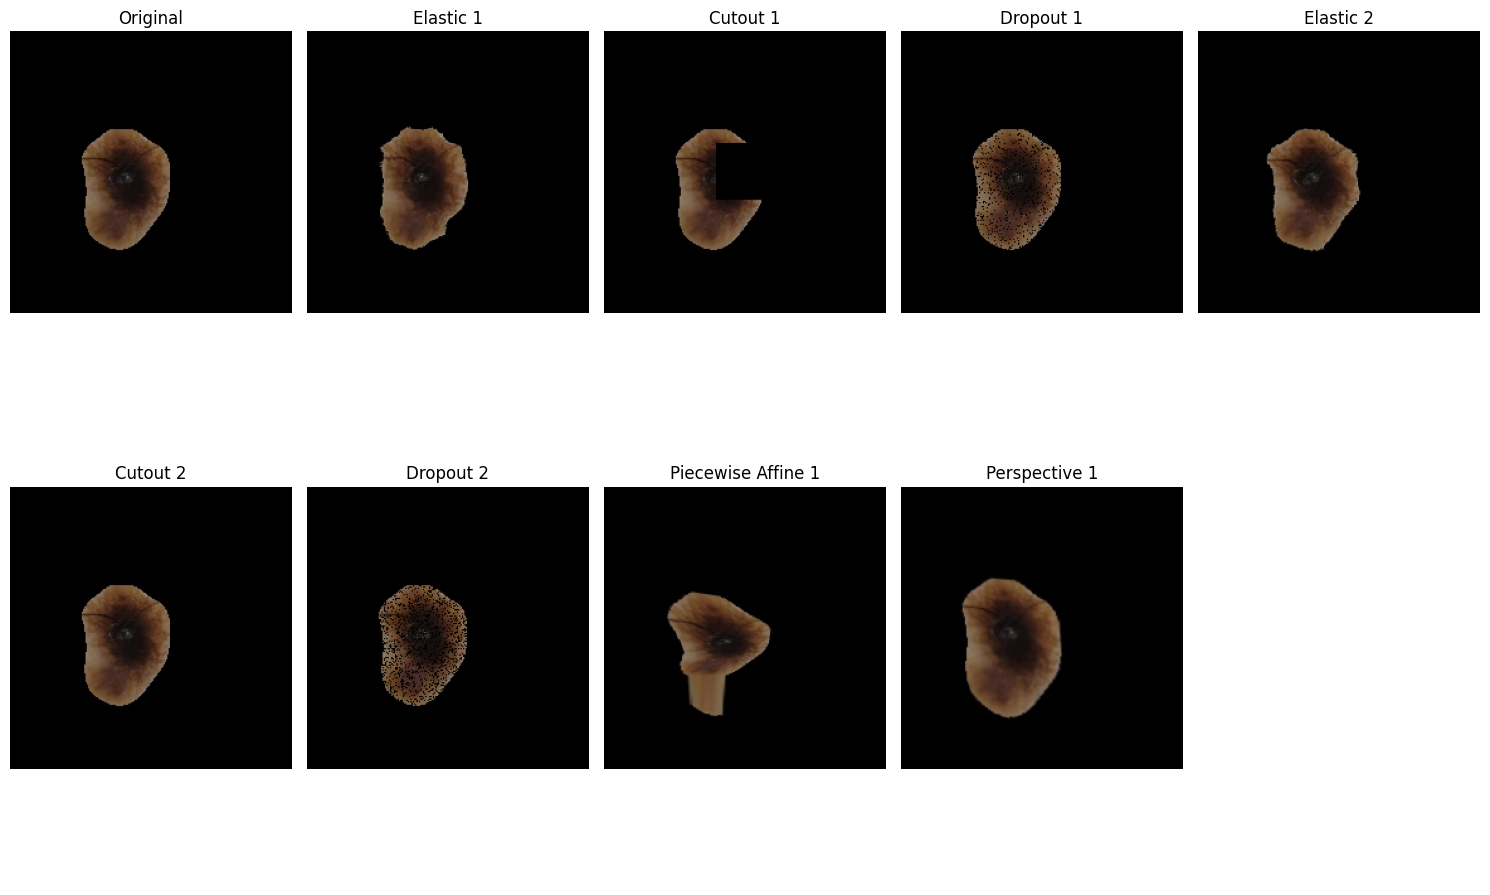

In [ ]:
display_augmentations(augmenters_warping, 2)

In [ ]:
def display_nested_augments(isic_id):
    dups = get_duplicates(df_balanced1, isic_id)
    four_class = dups.iloc[0]['four_class']
    in_img_path = f'/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/training/{four_class}/{isic_id}.jpg'
    img = cv2.imread(in_img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images = [img_rgb]
    titles = ['Original']

    # Shuffle the augmenters at the start
    random.shuffle(augmenters_color)
    random.shuffle(augmenters_geometric)
    random.shuffle(augmenters_warping)

    if len(dups) > 1:
        for i in range(1, len(dups)):
            augmenter_idx1 = (i) % len(augmenters_color)
            augmenter_func1 = augmenters_color[augmenter_idx1][1]

            augmenter_idx2 = (i) % len(augmenters_geometric)
            augmenter_func2 = augmenters_geometric[augmenter_idx2][1]

            augmenter_idx3 = (i) % len(augmenters_warping)
            augmenter_func3 = augmenters_warping[augmenter_idx3][1]

            augmented_img = augmenter_func3.augment_image(augmenter_func2.augment_image(augmenter_func1.augment_image(img)))
            augmented_img_rgb = cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB)

            images.append(augmented_img_rgb)
            titles.append(f'{augmenters_color[augmenter_idx1][0]},\n{augmenters_geometric[augmenter_idx2][0]},\n{augmenters_warping[augmenter_idx3][0]}')

    # Set up the layout
    num_images = len(images)
    if num_images > 7:
        rows = 2
        cols = math.ceil(num_images / 2)
    else:
        rows = 1
        cols = num_images

    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    axes = axes.flatten()

    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    for i in range(num_images, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

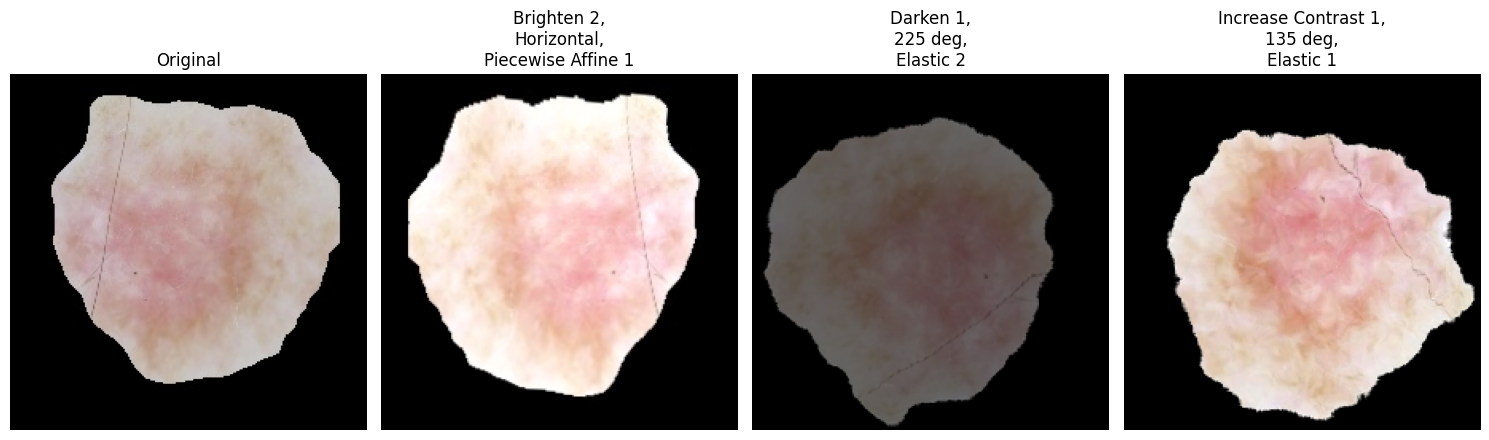

In [ ]:
display_nested_augments('ISIC_0071425')

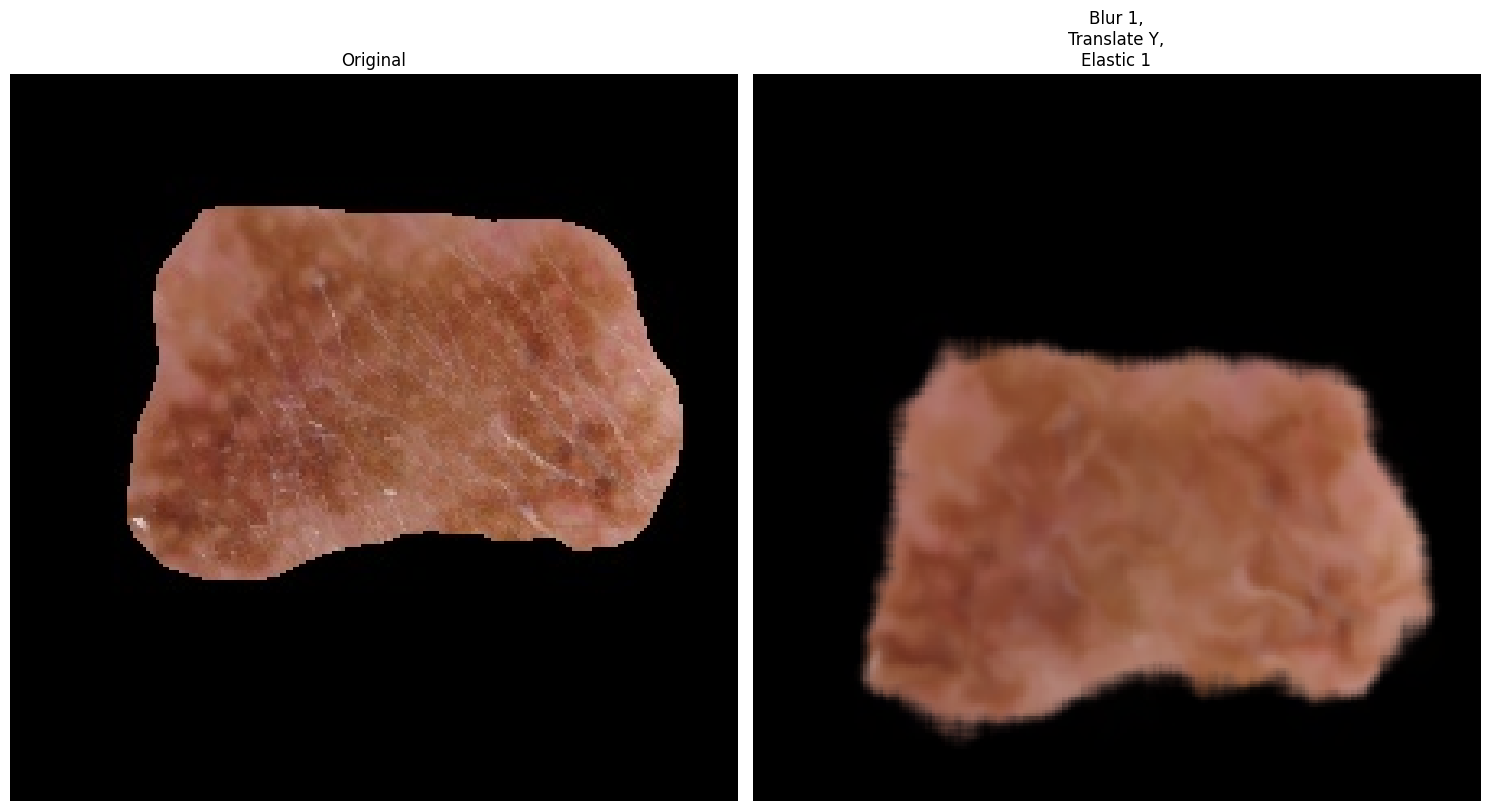

In [ ]:
display_nested_augments('ISIC_0069406')

In [ ]:
# Function to augment and save the image
def augment_image(isic_id):
    dups = get_duplicates(df_balanced1, isic_id)
    four_class = dups.iloc[0]['four_class']
    # Define input and output paths
    in_img_path = f'/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_maskeddenoised_data/training/{four_class}/{isic_id}.jpg'
    out_img_dir = f'/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_augmented/{four_class}'
    # Ensure the output directory exists
    os.makedirs(out_img_dir, exist_ok=True)

    # Read the original image
    img = cv2.imread(in_img_path)
    # Check if the image was successfully loaded
    if img is None:
        print(f"Error: Could not read image at {in_img_path}. Skipping this image.")
        return
    # Save the original image
    original_out_path = os.path.join(out_img_dir, f'{isic_id}.jpg')
    success = cv2.imwrite(original_out_path, img)
    if success:
        print(f'Saved original image: {original_out_path}')

    # Shuffle the augmenters at the start
    random.shuffle(augmenters_color)
    random.shuffle(augmenters_geometric)
    random.shuffle(augmenters_warping)

    if len(dups) > 1:
        for i in range(1, len(dups)):
            augmenter_idx1 = (i) % len(augmenters_color)
            augmenter_func1 = augmenters_color[augmenter_idx1][1]

            augmenter_idx2 = (i) % len(augmenters_geometric)
            augmenter_func2 = augmenters_geometric[augmenter_idx2][1]

            augmenter_idx3 = (i) % len(augmenters_warping)
            augmenter_func3 = augmenters_warping[augmenter_idx3][1]

            augmented_img = augmenter_func3.augment_image(augmenter_func2.augment_image(augmenter_func1.augment_image(img)))


            # Define the output path for augmented images
            aug_img_id = dups.iloc[i]['isic_id']
            aug_out_path = os.path.join(out_img_dir, f'{aug_img_id}.jpg')

            # Save augmented image
            success = cv2.imwrite(aug_out_path, augmented_img)
            if success:
                print(f'Saved augmented image with {augmenters_color[augmenter_idx1][0]}, {augmenters_geometric[augmenter_idx2][0]}, {augmenters_warping[augmenter_idx3][0]}: {aug_out_path}')


In [ ]:
df_model1_isic_unique = df_oversampled.isic_id.value_counts().index

In [ ]:
df_model1_isic_unique

Index(['ISIC_0072075', 'ISIC_0030661', 'ISIC_0028662', 'ISIC_0024612',
       'ISIC_0032773', 'ISIC_0055890', 'ISIC_0057680', 'ISIC_0024726',
       'ISIC_0026409', 'ISIC_0033022',
       ...
       'ISIC_0072942', 'ISIC_0073149', 'ISIC_0059894', 'ISIC_9822801',
       'ISIC_4467150', 'ISIC_0031729', 'ISIC_0072690', 'ISIC_9688617',
       'ISIC_0065987', 'ISIC_8342541'],
      dtype='object', name='isic_id', length=14679)

i should have changed the code so this wouldn't take as long, i think moving the read in directory on disk + not saving the originals in the augment folder (just adding them together when modeling) would save us alot of time. it's too late now though, it's already 180 min in

In [ ]:
df_model1_isic_unique = df_oversampled.isic_id.value_counts().index
# Loop through the dataset
for i in range(len(df_model1_isic_unique)):
    print(i)
    isic_id = df_model1_isic_unique[i]
    augment_image(isic_id)

Streaming output truncated to the last 5000 lines.
12179
Saved original image: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_augmented/malignant other/ISIC_0053715.jpg
12180
Saved original image: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_augmented/malignant other/ISIC_0053602.jpg
12181
Saved original image: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_augmented/malignant other/ISIC_0053626.jpg
12182
Saved original image: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_augmented/malignant other/ISIC_0053648.jpg
12183
Saved original image: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_augmented/nevus/ISIC_0010069.jpg
12184
Saved original image: /content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_augmented/nevus/ISIC_0067242.jpg
12185
Saved original image: /content/drive/MyDrive/MIDS 210A - Capstone Project/C

In [ ]:
df_balanced1.shape

(24104, 8)

Checking if total number of images matches up

In [ ]:
# Path to the main directory
main_directory = '/content/drive/MyDrive/MIDS 210A - Capstone Project/Code/Datasets/four_class_augmented/'

# Count the total number of images in all subfolders
total_images = sum(
    len(files) for _, _, files in os.walk(main_directory)
    if files  # Filter only files (to ignore empty folders)
)

print("Total number of images:", total_images)

Total number of images: 24104


**Placed augment folder in the original folder, renamed to training_augmented. old training named to training_old (so rerunning the cell will not work unless changed)**